***ViT Inference and Fine‑Tuning vs. CNN on Small Datasets***

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Training CNN (ResNet18)...


/tmp/ipython-input-1282918522.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/3 | Loss: 1.7118 | Val Acc: 0.5200


/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/3 | Loss: 1.4882 | Val Acc: 0.7025


/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/3 | Loss: 1.2241 | Val Acc: 0.7850

Training ViT (ViT-Tiny)...


/tmp/ipython-input-1282918522.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/3 | Loss: 0.8533 | Val Acc: 0.8875


/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/3 | Loss: 0.2106 | Val Acc: 0.9225


/tmp/ipython-input-1282918522.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/3 | Loss: 0.0841 | Val Acc: 0.9125


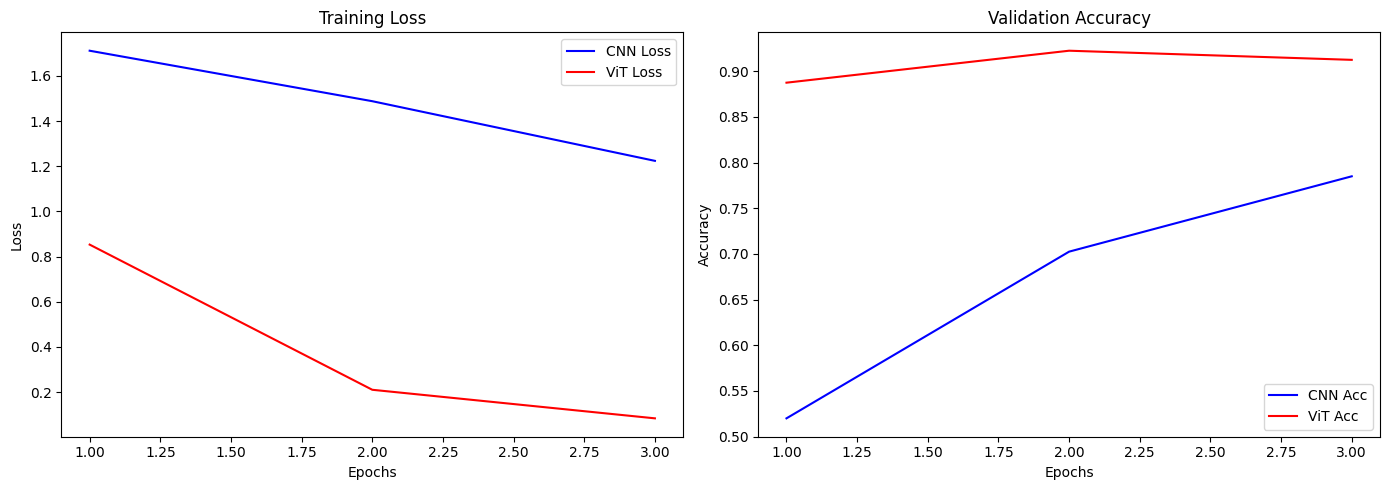


--- CNN (ResNet18) Evaluation ---
              precision    recall  f1-score   support

   buildings       0.94      0.69      0.80        68
      forest       1.00      0.99      0.99        72
     glacier       0.65      0.88      0.75        65
    mountain       0.67      0.82      0.73        71
         sea       0.96      0.38      0.55        63
      street       0.72      0.93      0.81        61

    accuracy                           0.79       400
   macro avg       0.82      0.78      0.77       400
weighted avg       0.82      0.79      0.78       400



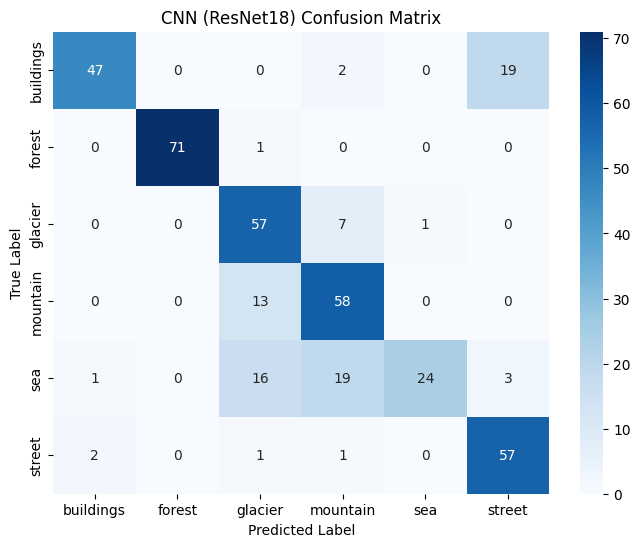


--- ViT (Tiny) Evaluation ---
              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92        68
      forest       0.99      1.00      0.99        72
     glacier       0.92      0.75      0.83        65
    mountain       0.80      0.93      0.86        71
         sea       1.00      0.92      0.96        63
      street       0.88      0.95      0.91        61

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400



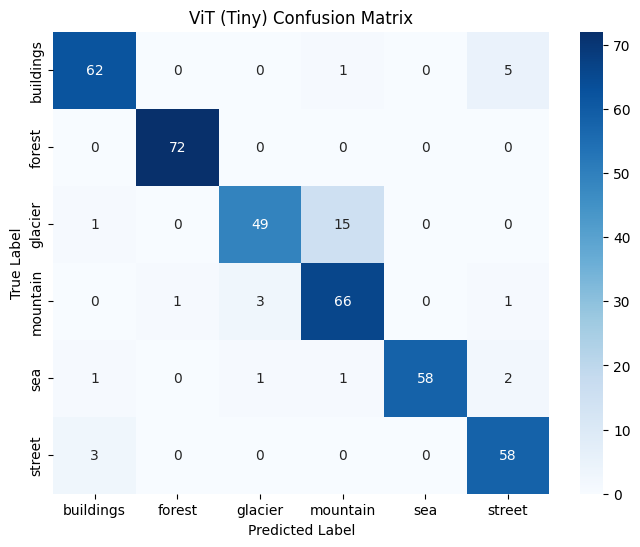

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import timm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data(data_dir, batch_size=64, img_size=224, max_images=2000):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    if len(dataset) > max_images:
        indices = torch.randperm(len(dataset))[:max_images]
        dataset = Subset(dataset, indices)
        dataset.classes = dataset.dataset.classes

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, dataset.classes

def build_cnn(num_classes):
    model = timm.create_model('resnet18', pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def build_vit(num_classes):
    model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
    num_features = model.head.in_features
    model.head = nn.Linear(num_features, num_classes)
    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    scaler = torch.cuda.amp.GradScaler()
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        val_acc, _, _ = get_predictions(model, val_loader, device)

        history['train_loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model, history

def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc, all_labels, all_preds

def plot_history(cnn_hist, vit_hist):
    epochs = range(1, len(cnn_hist['train_loss']) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, cnn_hist['train_loss'], 'b-', label='CNN Loss')
    plt.plot(epochs, vit_hist['train_loss'], 'r-', label='ViT Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, cnn_hist['val_acc'], 'b-', label='CNN Acc')
    plt.plot(epochs, vit_hist['val_acc'], 'r-', label='ViT Acc')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def show_evaluation(model, loader, device, classes, model_name):
    acc, y_true, y_pred = get_predictions(model, loader, device)

    print(f"\n--- {model_name} Evaluation ---")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- MAIN EXECUTION ---
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 1e-4

if os.path.exists(DATA_DIR):
    device = get_device()
    train_loader, val_loader, class_names = prepare_data(DATA_DIR, BATCH_SIZE, max_images=2000)
    print(f"Classes: {class_names}")

    print("\nTraining CNN (ResNet18)...")
    cnn_model = build_cnn(len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
    cnn_model, cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer_cnn, EPOCHS, device)

    print("\nTraining ViT (ViT-Tiny)...")
    vit_model = build_vit(len(class_names))
    optimizer_vit = optim.Adam(vit_model.parameters(), lr=LEARNING_RATE)
    vit_model, vit_history = train_model(vit_model, train_loader, val_loader, criterion, optimizer_vit, EPOCHS, device)

    # 1. Plot Training Curves
    plot_history(cnn_history, vit_history)

    # 2. Detailed Metrics & Confusion Matrix
    show_evaluation(cnn_model, val_loader, device, class_names, "CNN (ResNet18)")
    show_evaluation(vit_model, val_loader, device, class_names, "ViT (Tiny)")